<h1 style="color:navy;">Fault Detection in Gas Turbine Engines using Sensor Data</h1>
<p><strong>By: Garey Salinas</strong></p>

## Overview

This notebook analyzes sensor data from industrial gas turbine engines to detect faults and support predictive maintenance. The main goal is to develop machine learning models that can accurately classify failures in gas compressors. This is critical for midstream pipeline operations where turbines drive compression systems.

## Dataset

- **Source:** Gas Turbine Engine Fault Detection Dataset (Kaggle)
- **Contents:** Sensor readings such as temperatures, pressures, rotational speeds, and a labeled fault indicator (0 = normal, 1 = fault).
- **Structure:** 1,386 rows × 10 columns, all continuous features except the binary fault label.

The dataframe has 1,386 rows and 10 columns. All columns are complete with no missing values. The features are mostly continuous floating point numbers, and the target column is Fault (int64), which represents a classification label (e.g., 0 = normal, 1 = fault). We will change the type of variable of column Fault to represent a boolean value.

| Column Name                      | Description                   | Unit/Type      |
|----------------------------------|-------------------------------|----------------|
| Temperature (°C)                 | Turbine temperature           | °C (float)     |
| RPM                              | Rotations per minute          | RPM (float)    |
| Torque (Nm)                      | Torque                        | Nm (float)     |
| Vibrations (mm/s)                | Vibration level               | mm/s (float)   |
| Power Output (MW)                | Power output                  | MW (float)     |
| Fuel Flow Rate (kg/s)            | Fuel flow rate                | kg/s (float)   |
| Air Pressure (kPa)               | Air pressure                  | kPa (float)    |
| Exhaust Gas Temperature (°C)     | Exhaust gas temperature       | °C (float)     |
| Oil Temperature (°C)             | Oil temperature               | °C (float)     |
| Fault (target)                   | Fault status (0/1)            | int (0 or 1)   |

## Objectives

- Build classification models to detect and classify faults.
- Engineer features (e.g., pressure ratios, temperature differentials, time-based deltas).
- Apply outlier detection to identify sensor anomalies.
- Use time-series segmentation to capture operational patterns.

## Techniques and Tools

**Machine Learning Models:**
- Random Forest
- XGBoost
- Support Vector Machines

**Outlier Detection:**
- Isolation Forest
- DBSCAN

**Time-Series Analysis:**
- Windowing and segmentation
- Trend decomposition (optional for EDA)

**Python Libraries:**
- scikit-learn
- xgboost
- numpy
- pandas
- seaborn
- matplotlib

## Value and Impact

This project aims to:
- Detect mechanical degradation early
- Reduce equipment downtime
- Enhance pipeline safety
- Lower operational costs


## Import Libraries

In [127]:
# import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')  

## Load Dataset

In [128]:
# Load the dataset
data = pd.read_csv('data/gas_turbine_fault_detection.csv')

data.head()

Temperature (°C)           RPM  Torque (Nm)  Vibrations (mm/s)  \
0        924.835708  15650.870645  3464.645167           1.675087   
1        893.086785  15780.755598  3190.276340           2.042084   
2        932.384427  15016.002075  3401.769251           2.006414   
3        976.151493  14623.291065  3443.024901           2.239914   
4        888.292331  15229.986071  3448.764050           1.865677   

   Power Output (MW)  Fuel Flow Rate (kg/s)  Air Pressure (kPa)  \
0          96.347590               2.265294          146.245460   
1          83.288302               2.755950          166.812134   
2         120.358735               2.574244          133.494161   
3         104.689781               2.497101          140.141635   
4          95.080431               2.763689          109.795667   

   Exhaust Gas Temperature (°C)  Oil Temperature (°C)  Fault  
0                    517.611726             90.530958      0  
1                    500.196460            136.047350      0  
2                    516.272719            124.910039      0  
3                    475.731083            123.298231      1  
4                    546.737163            119.382239      1

## Exploratory Data Analysis

In [129]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Temperature (°C)              1386 non-null   float64
 1   RPM                           1386 non-null   float64
 2   Torque (Nm)                   1386 non-null   float64
 3   Vibrations (mm/s)             1386 non-null   float64
 4   Power Output (MW)             1386 non-null   float64
 5   Fuel Flow Rate (kg/s)         1386 non-null   float64
 6   Air Pressure (kPa)            1386 non-null   float64
 7   Exhaust Gas Temperature (°C)  1386 non-null   float64
 8   Oil Temperature (°C)          1386 non-null   float64
 9   Fault                         1386 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 108.4 KB


In [130]:
df.describe()

Temperature (°C)           RPM  Torque (Nm)  Vibrations (mm/s)  \
count       1386.000000   1386.000000  1386.000000        1386.000000   
mean         901.623932  15022.591497  3494.764285           1.978964   
std           49.381498    490.048647   203.828153           0.494025   
min          737.936633  13490.243922  2901.772806           0.411648   
25%          868.117411  14688.039309  3355.445978           1.658465   
50%          901.964879  15016.737353  3490.639925           1.989549   
75%          932.692748  15346.057959  3627.482077           2.322288   
max         1092.636575  16596.553784  4285.247541           3.556455   

       Power Output (MW)  Fuel Flow Rate (kg/s)  Air Pressure (kPa)  \
count        1386.000000            1386.000000         1386.000000   
mean           99.497230               2.505591          150.320568   
std            10.309697               0.316582           19.430192   
min            71.004861               1.349003           93.961769   
25%            92.387182               2.296762          137.688214   
50%            99.378143               2.500537          150.464896   
75%           106.454488               2.724751          163.130104   
max           135.290552               3.513215          213.155426   

       Exhaust Gas Temperature (°C)  Oil Temperature (°C)        Fault  
count                   1386.000000           1386.000000  1386.000000  
mean                     498.865296            120.061923     0.306638  
std                       28.793950             10.005188     0.461264  
min                      382.327992             86.244209     0.000000  
25%                      479.238499            113.652494     0.000000  
50%                      498.865627            119.968056     0.000000  
75%                      518.337798            126.570199     1.000000  
max                      587.423276            153.777682     1.000000

### Distribution Breakdown of Each Column

- **Temperature (°C)**
  - Mean: 901.62, Std: 49.38
  - Min: 737.94, 25%: 868.12, Median: 901.96, 75%: 932.69, Max: 1092.64
  - Most values are centered around 900°C, moderate spread.

- **RPM**
  - Mean: 15022.59, Std: 490.05
  - Min: 13490.24, 25%: 14688.04, Median: 15016.74, 75%: 15346.06, Max: 16596.55
  - Tightly clustered around 15,000 RPM.

- **Torque (Nm)**
  - Mean: 3494.76, Std: 203.83
  - Min: 2901.77, 25%: 3355.45, Median: 3490.64, 75%: 3627.48, Max: 4285.25
  - Most values near 3,500 Nm.

- **Vibrations (mm/s)**
  - Mean: 1.98, Std: 0.49
  - Min: 0.41, 25%: 1.66, Median: 1.99, 75%: 2.32, Max: 3.56
  - Slight right skew, most between 1.6 and 2.3 mm/s.

- **Power Output (MW)**
  - Mean: 99.50, Std: 10.31
  - Min: 71.00, 25%: 92.39, Median: 99.38, 75%: 106.45, Max: 135.29
  - Most values close to 100 MW.

- **Fuel Flow Rate (kg/s)**
  - Mean: 2.51, Std: 0.32
  - Min: 1.35, 25%: 2.30, Median: 2.50, 75%: 2.72, Max: 3.51
  - Most between 2.3 and 2.7 kg/s.

- **Air Pressure (kPa)**
  - Mean: 150.32, Std: 19.43
  - Min: 93.96, 25%: 137.69, Median: 150.46, 75%: 163.13, Max: 213.16
  - Centered around 150 kPa.

- **Exhaust Gas Temperature (°C)**
  - Mean: 498.87, Std: 28.79
  - Min: 382.33, 25%: 479.24, Median: 498.87, 75%: 518.34, Max: 587.42
  - Most values near 500°C.

- **Oil Temperature (°C)**
  - Mean: 120.06, Std: 10.01
  - Min: 86.24, 25%: 113.65, Median: 119.97, 75%: 126.57, Max: 153.78
  - Most between 113.65 and 126.57°C.

- **Fault (target)**
  - Mean: 0.31, Std: 0.46
  - Min: 0, 25%: 0, Median: 0, 75%: 1, Max: 1
  - 31% faults (1), 69% normal (0); imbalanced data.

### Check for Missing Values

In [131]:
# Check for missing values
df.isnull().sum()

Temperature (°C)                0
RPM                             0
Torque (Nm)                     0
Vibrations (mm/s)               0
Power Output (MW)               0
Fuel Flow Rate (kg/s)           0
Air Pressure (kPa)              0
Exhaust Gas Temperature (°C)    0
Oil Temperature (°C)            0
Fault                           0
dtype: int64

### Check for Duplicate Rows

In [132]:
# Perform basic data cleaning
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')
# Remove duplicate rows if any

Number of duplicate rows: 0


### Change Column Names

In [133]:
# Change the column names to lowercase
df.columns = df.columns.str.lower()
# Rename columns for easier access
df.rename(columns={
    'temperature (°c)': 'temperature',
    'torque (nm)': 'torque',
    'vibrations (mm/s)': 'vibrations',
    'power output (mw)': 'power_output',
    'fuel flow rate (kg/s)': 'fuel_flow_rate',
    'air pressure (kpa)': 'air_pressure',
    'exhaust gas temperature (°c)': 'exhaust_gas_temperature',
    'oil temperature (°c)': 'oil_temperature'
}, inplace=True)
# Check the data types of the columns
df.dtypes


temperature                float64
rpm                        float64
torque                     float64
vibrations                 float64
power_output               float64
fuel_flow_rate             float64
air_pressure               float64
exhaust_gas_temperature    float64
oil_temperature            float64
fault                        int64
dtype: object

### Change Fault Type to Boolean

In [134]:
# Convert Fault column to boolean
df['fault'] = df['fault'].astype(bool)

### Feature Engineering

In [146]:
# Thermal efficiency calculation
df['exhaust_efficiency_ratio'] = df['exhaust_gas_temperature'] / df['temperature']

# RPM-to-Torque Ratio
# Inverse of torque-speed, could catch imbalance or slippage
df['rpm_torque_ratio'] = df['rpm'] / (df['torque'] + 1e-6)

# Normalized Vibrations
# Vibrations relative tot RPM tot detect dynamic imbalance
df['vibrations_normalized'] = df['vibrations'] / (df['rpm'] + 1e-6)

# Oil temperature to Torque Ratio
df['oil_temp_torque_ratio'] = df['oil_temperature'] / (df['torque'])

# Power and Torque Ratios
# These ratios can help identify performance issues
df['power_torque_ratio'] = df['power_output'] / (df['torque'])

# Oil temperature to RPM Ratio
df['oil_temp_rpm_ratio'] = df['oil_temperature'] / (df['rpm'] + 1e-6)

# Oil temperature to Power Ratio
df['oil_temp_power_ratio'] = df['oil_temperature'] / (df['power_output'] + 1e-6)

# Oil temperature to Vibrations Ratio
# This ratio can help identify issues related to lubrication and cooling
df['oil_temp_vibrations_ratio'] = df['oil_temperature'] / (df['vibrations'] + 1e-6)

# Oil temperature to Exhaust Gas Temperature Ratio
# This ratio can help identify issues related to thermal management
df['oil_temp_exhaust_ratio'] = df['oil_temperature'] / (df['exhaust_gas_temperature'] + 1e-6)

# Power output per unit vibrations
# This ratio can help identify performance issues related to vibrations
df['power_vibrations_ratio'] = df['power_output'] / (df['vibrations'] + 1e-6)

# Torque to Fuel Flow Rate Ratio
# This ratio can help identify issues related to fuel efficiency
df['torque_fuel_ratio'] = df['torque'] / (df['fuel_flow_rate'] + 1e-6)

# Air pressure to Fuel Flow Rate Ratio
# This ratio can help identify issues related to air-fuel mixture
df['comp_pressure_ratio'] = df['air_pressure'] / df['fuel_flow_rate']

# Fuel Flow Rate to RPM Ratio
# This ratio can help identify issues related to fuel efficiency at different RPMs
df['fuel_flow_per_rpm'] = df['fuel_flow_rate'] / df['rpm']

# Torque to RPM Ratio
# This ratio can help identify issues related to torque production at different RPMs
df['torque_per_rpm'] = df['torque'] / (df['rpm'] + 1e-6)

# Power to RPM Ratio
# This ratio can help identify issues related to power production at different RPMs
df['power_per_rpm'] = df['power_output'] / (df['rpm'] + 1e-6)

# Vibrations to torque Ratio
# This ratio can help identify issues related to vibrations and torque production
df['vibrations_torque_ratio'] = df['vibrations'] / (df['torque'] + 1e-6)

# Temperature to Torque Ratio
# This ratio can help identify issues related to temperature and torque production
df['temperature_torque_ratio'] = df['temperature'] / (df['torque'] + 1e-6)

# Exhaust Gas Temperature to Torque Ratio
# This ratio can help identify issues related to exhaust gas temperature and torque production
df['exhaust_temp_torque_ratio'] = df['exhaust_gas_temperature'] / (df['torque'] + 1e-6)

# Air Pressure to Torque Ratio
# This ratio can help identify issues related to air pressure and torque production
df['air_pressure_torque_ratio'] = df['air_pressure'] / (df['torque'] + 1e-6)

# Torque per Fuel Flow Rate
# This ratio can help identify issues related to fuel efficiency and torque production
df['torque_per_fuel'] = df['torque'] / (df['fuel_flow_rate'] + 1e-6)



In [145]:
df.dtypes

temperature                    float64
rpm                            float64
torque                         float64
vibrations                     float64
power_output                   float64
fuel_flow_rate                 float64
air_pressure                   float64
exhaust_gas_temperature        float64
oil_temperature                float64
fault                             bool
power_torque_ratio             float64
comp_pressure_ratio            float64
fuel_flow_per_rpm              float64
torque_speed_ratio             float64
power_rpm_ratio                float64
vibration_torque_ratio         float64
temperature_torque_ratio       float64
exhaust_temp_torque_ratio      float64
oil_temp_torque_ratio          float64
air_pressure_torque_ratio      float64
fuel_flow_rate_torque_ratio    float64
oil_temp_vibrations_ratio      float64
exhaust_efficiency_ratio       float64
rpm_torque_ratio               float64
vibrations_normalized          float64
oil_temp_rpm_ratio       

### Univariate Analysis

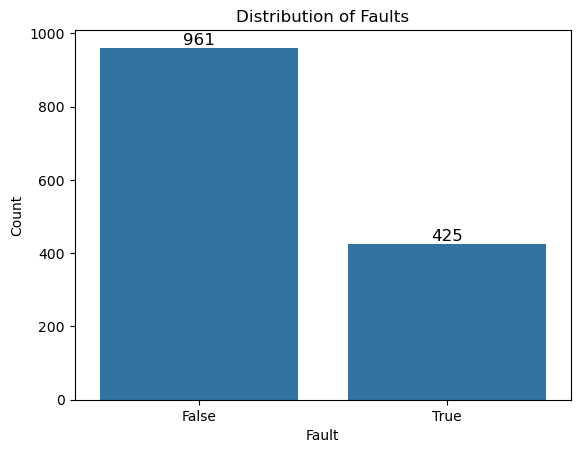

In [137]:
# Visualize the distribution of the target variable with value counts on bars
ax = sns.countplot(x='fault', data=df)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')
plt.title('Distribution of Faults')
plt.xlabel('Fault')
plt.ylabel('Count')
plt.show()

The bar chart above shows the distribution of the target variable Fault in the dataset. There are 961 instances labeled as "False" (no fault) and 425 instances labeled as "True" (fault). This indicates that approximately 31% of the data represents fault conditions, while 69% represents normal operation, highlighting a moderate class imbalance in the dataset.

In [138]:
# Get all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

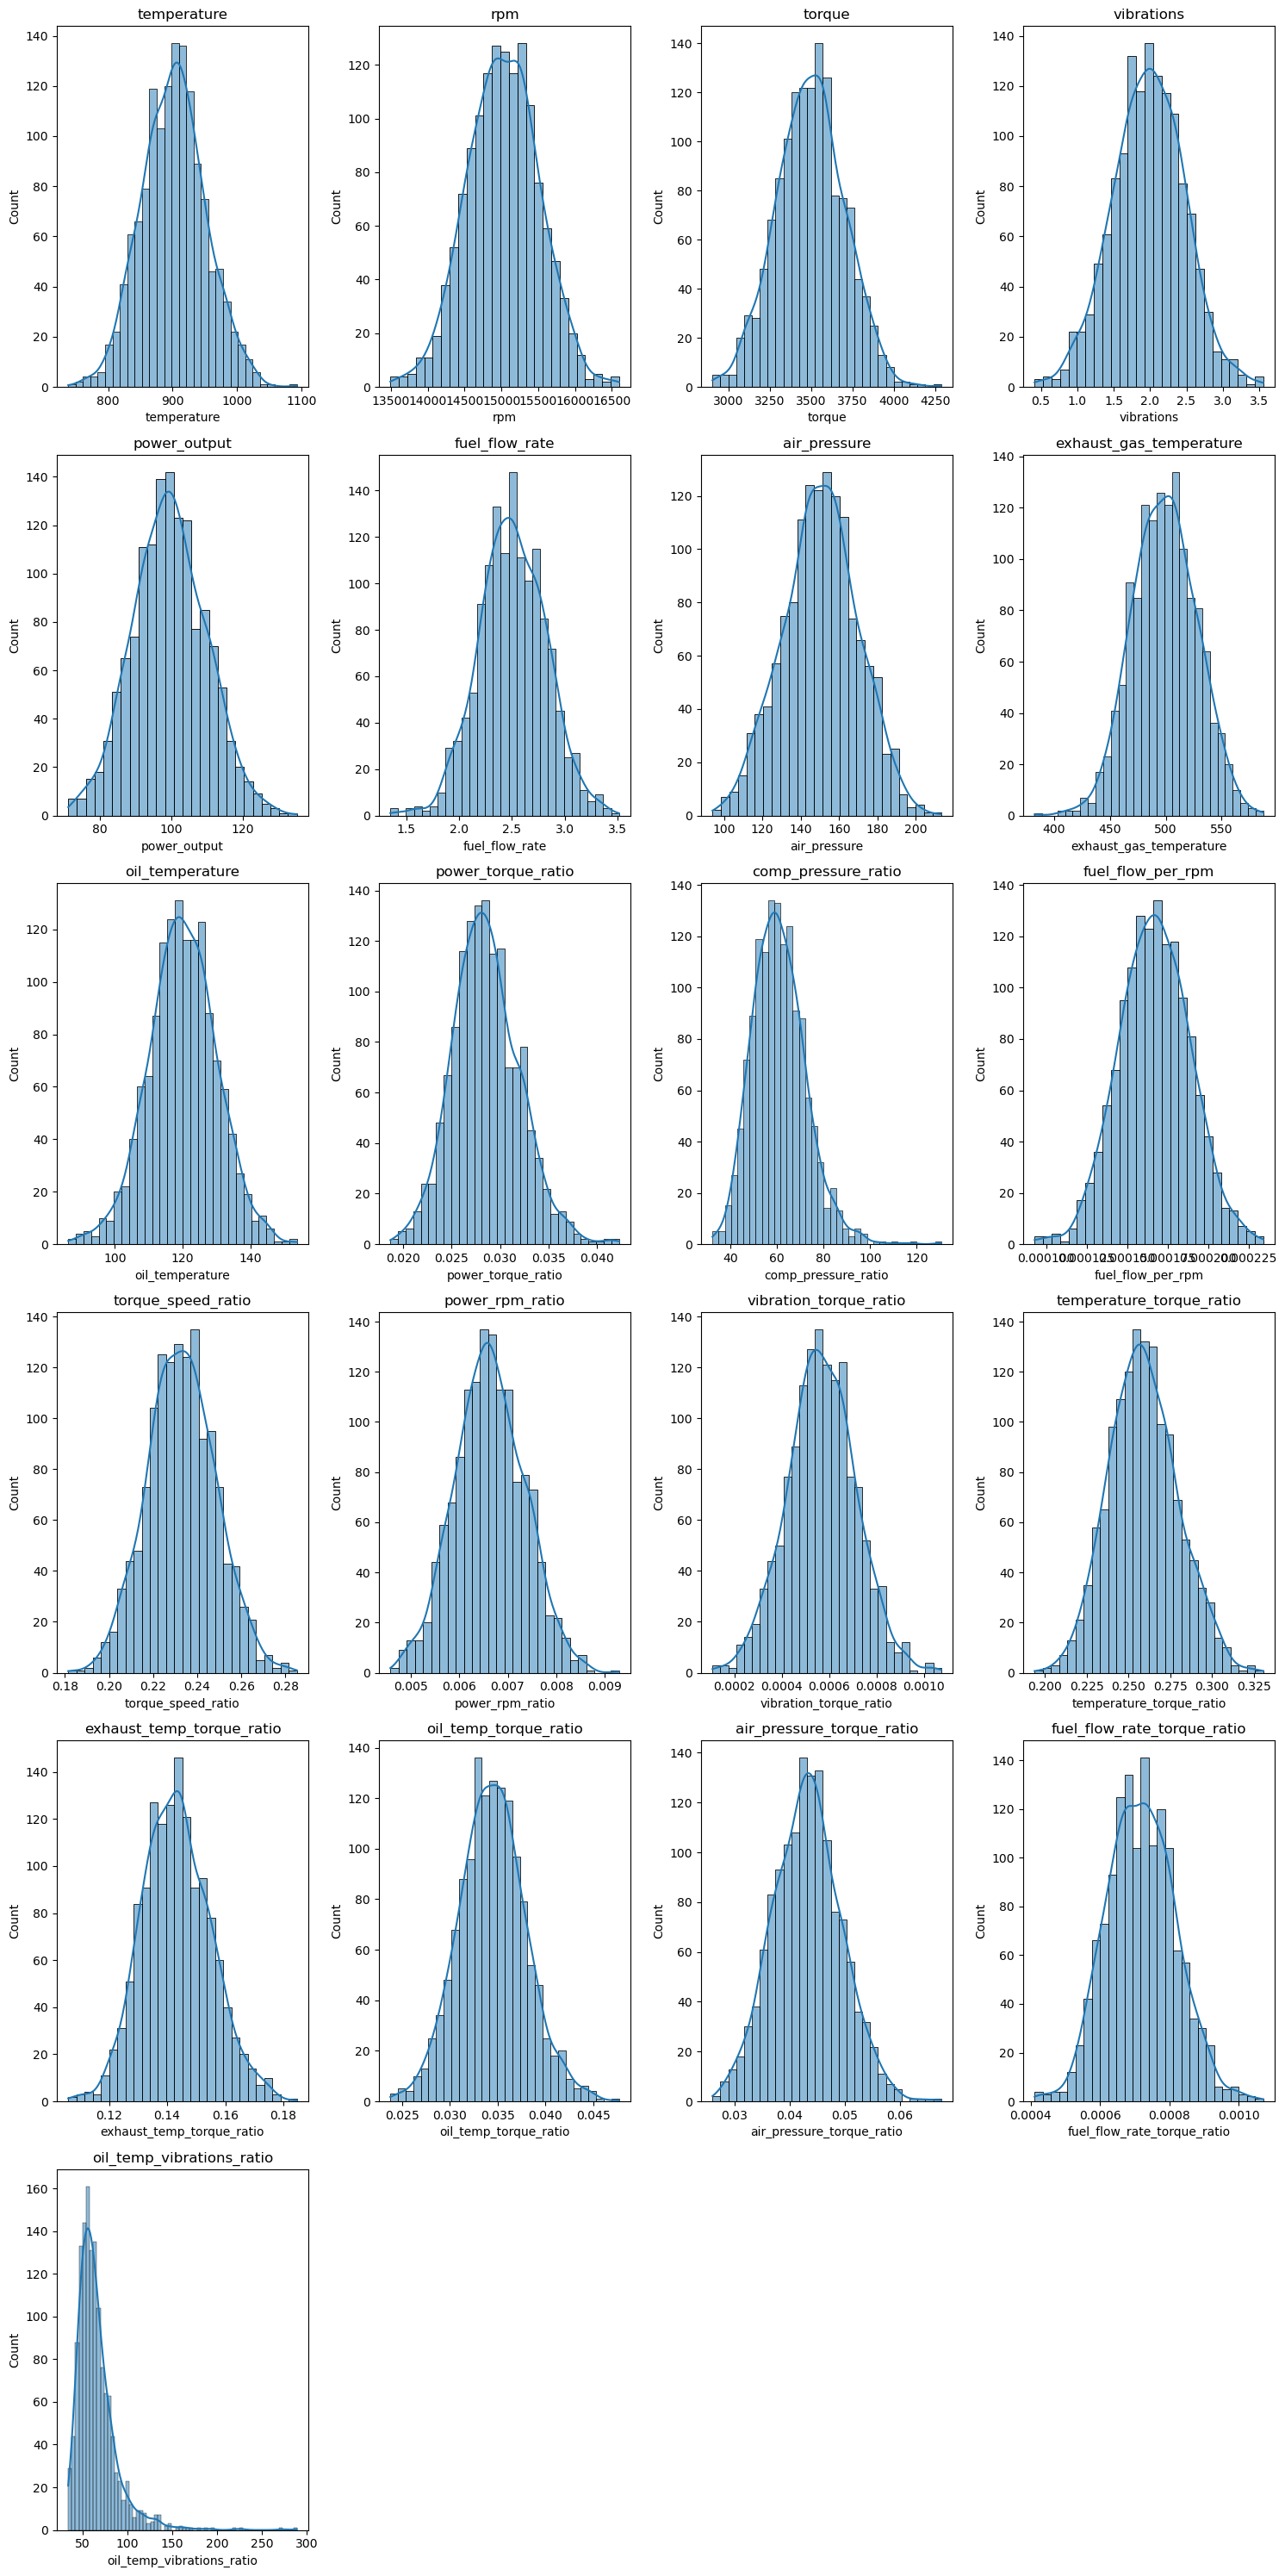

In [140]:
# Visualize the distribution of each feature
# Adjust the number of rows and columns dynamically
num_cols = len(numeric_cols)
num_rows = (num_cols + 3) // 4  # Calculate rows needed for 4 columns per row

plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure height based on rows
for i, column in enumerate(df[numeric_cols]):
    plt.subplot(num_rows, 4, i + 1)  # Adjust grid layout dynamically
    sns.histplot(df[column], kde=True)
    plt.title(column)
plt.tight_layout()

The figure displays the distribution of each feature in the dataset using histograms with kernel density estimates. Most sensor features, such as temperature, rpm, torque, vibrations, power output, fuel flow rate, air pressure, exhaust gas temperature, and oil temperature, exhibit approximately normal distributions centered around their respective means.

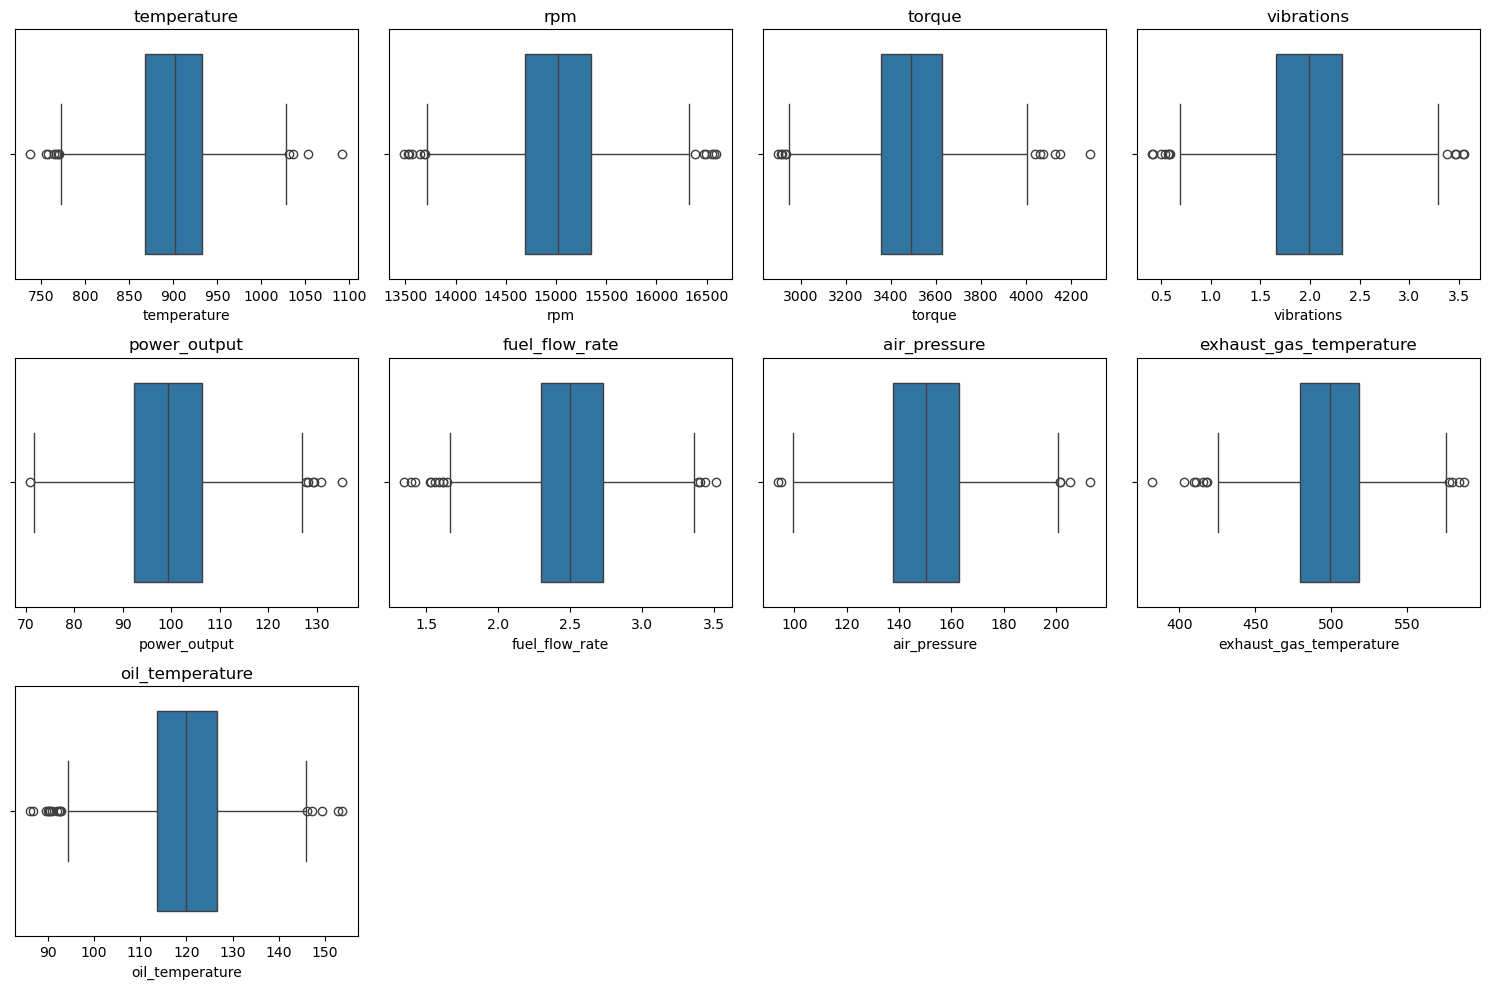

In [ ]:
# Visulize boxplot for each feature to check for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(df[numeric_cols]):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df[column])
    plt.title(column)
plt.tight_layout()

The boxplots displays the distribution and presence of outliers for each feature in the dataset. Most sensor features, such as temperature, rpm, torque, vibrations, power output, fuel flow rate, air pressure, exhaust gas temperature, and oil temperature, show a symmetric distribution with several outliers on both the lower and upper ends, as indicated by the points outside the whiskers.

### Multivariate Analysis

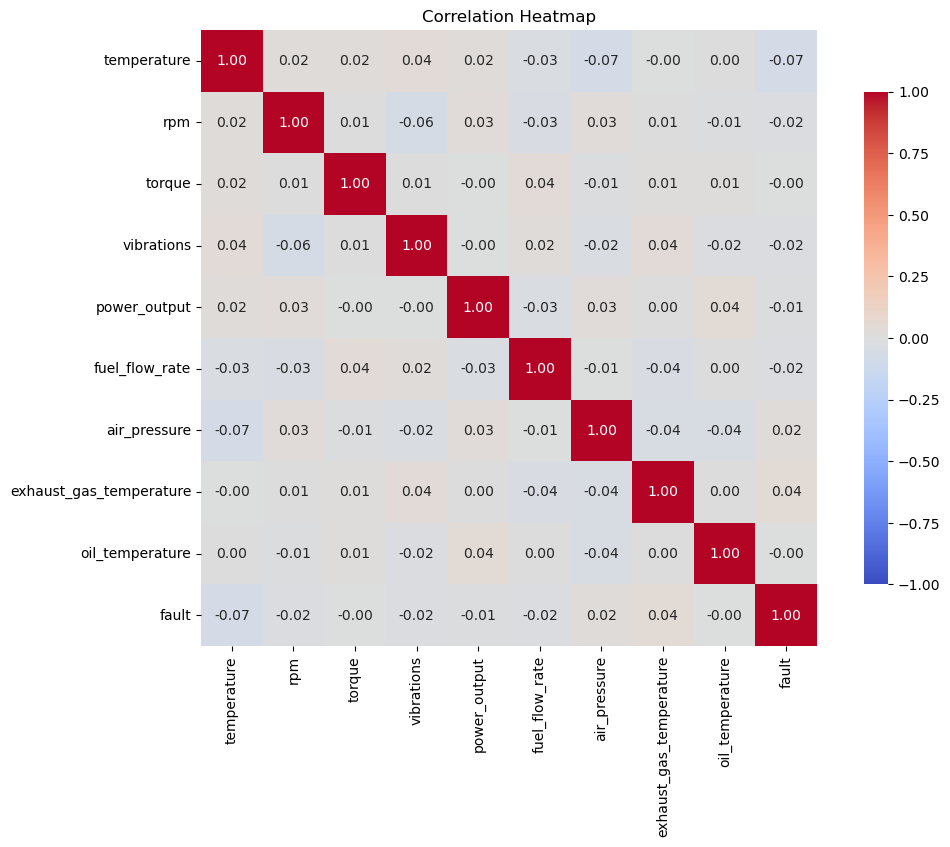

In [ ]:
# Create a heatmap to visualize the correlation between features with a better color palette and visible diagonal
plt.figure(figsize=(12, 8))
corr = df.corr()
#mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # Mask only the upper triangle, keep diagonal

sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',  # or 'crest', 'YlGnBu', etc.
    #mask=mask,
    vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap')
plt.show()


The correlation heatmap displays the pairwise correlation coefficients between all features in the dataset. Most features show very weak correlations with each other and with the target variable (fault), as indicated by values close to zero. No strong linear relationships are observed between the sensor readings, and the fault variable does not have a strong correlation with any single feature.

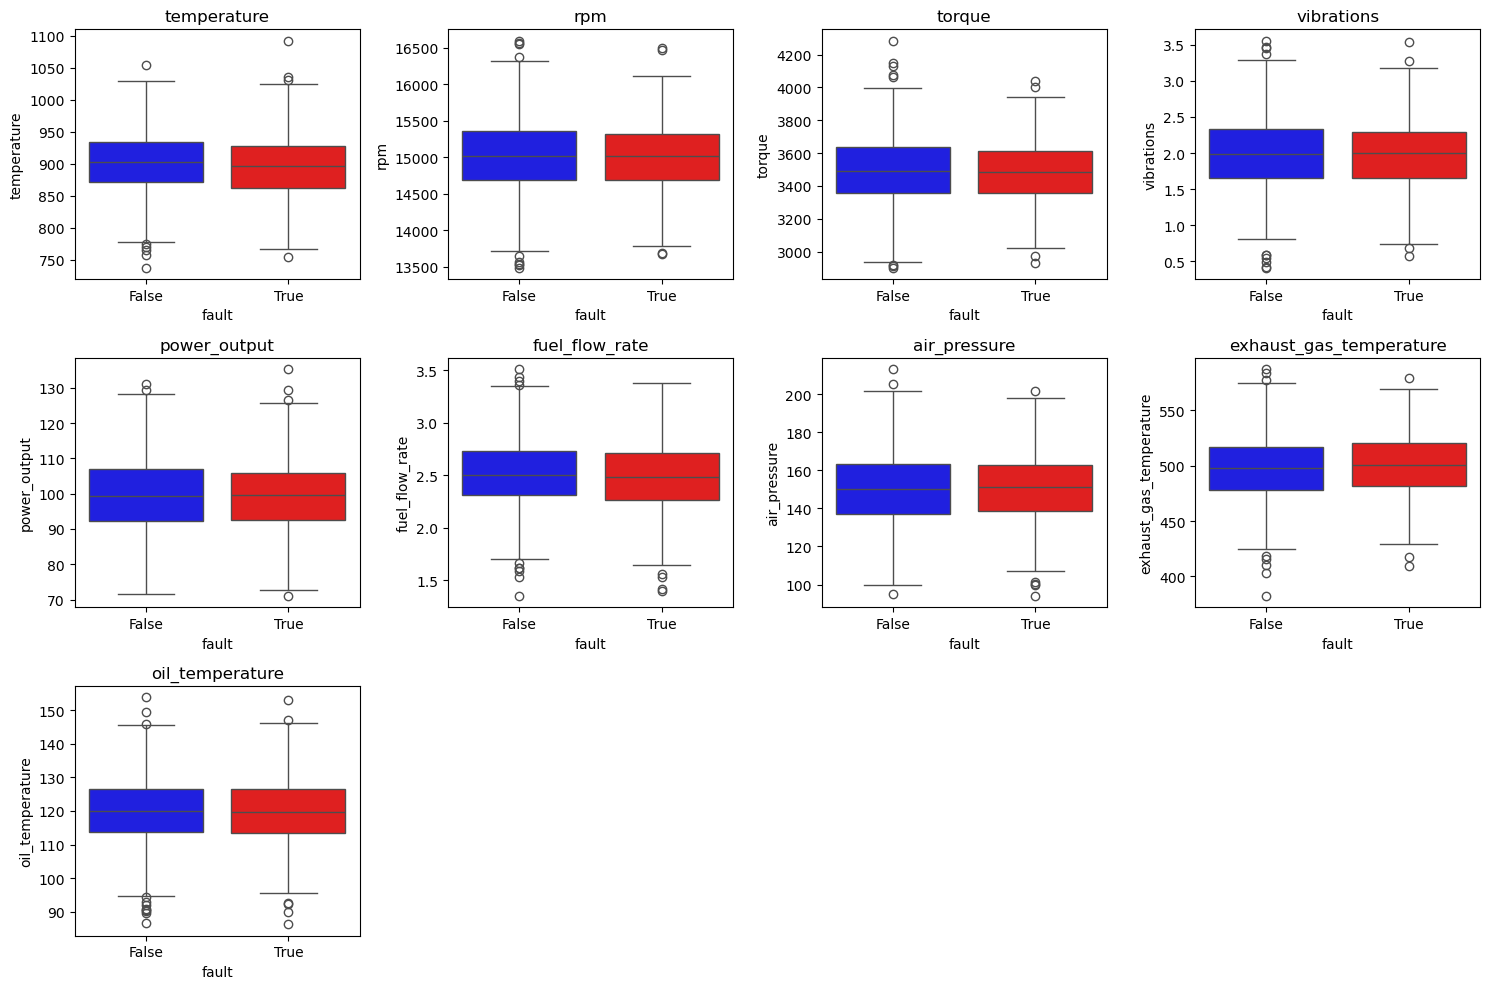

In [ ]:
# Visulalize the boxplot for each feature grouped by the fault status
plt.figure(figsize=(15, 10))
for i, column in enumerate(df[numeric_cols]):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='fault', y=column, data=df, palette={'True': 'red', 'False': 'blue'})
    plt.title(column)
plt.tight_layout()

The boxplots above show the distribution of each sensor feature grouped by fault status (False = no fault, True = fault). For all features, the median and interquartile ranges are similar between the fault and non-fault groups, indicating that there are no strong univariate differences between the two classes. Some features, such as temperature, rpm, and power output, display a few more extreme values (outliers) in both groups. Overall, the boxplots suggest that distinguishing faults based on a single feature may be challenging, and a combination of features or more advanced modeling may be necessary for effective fault detection.

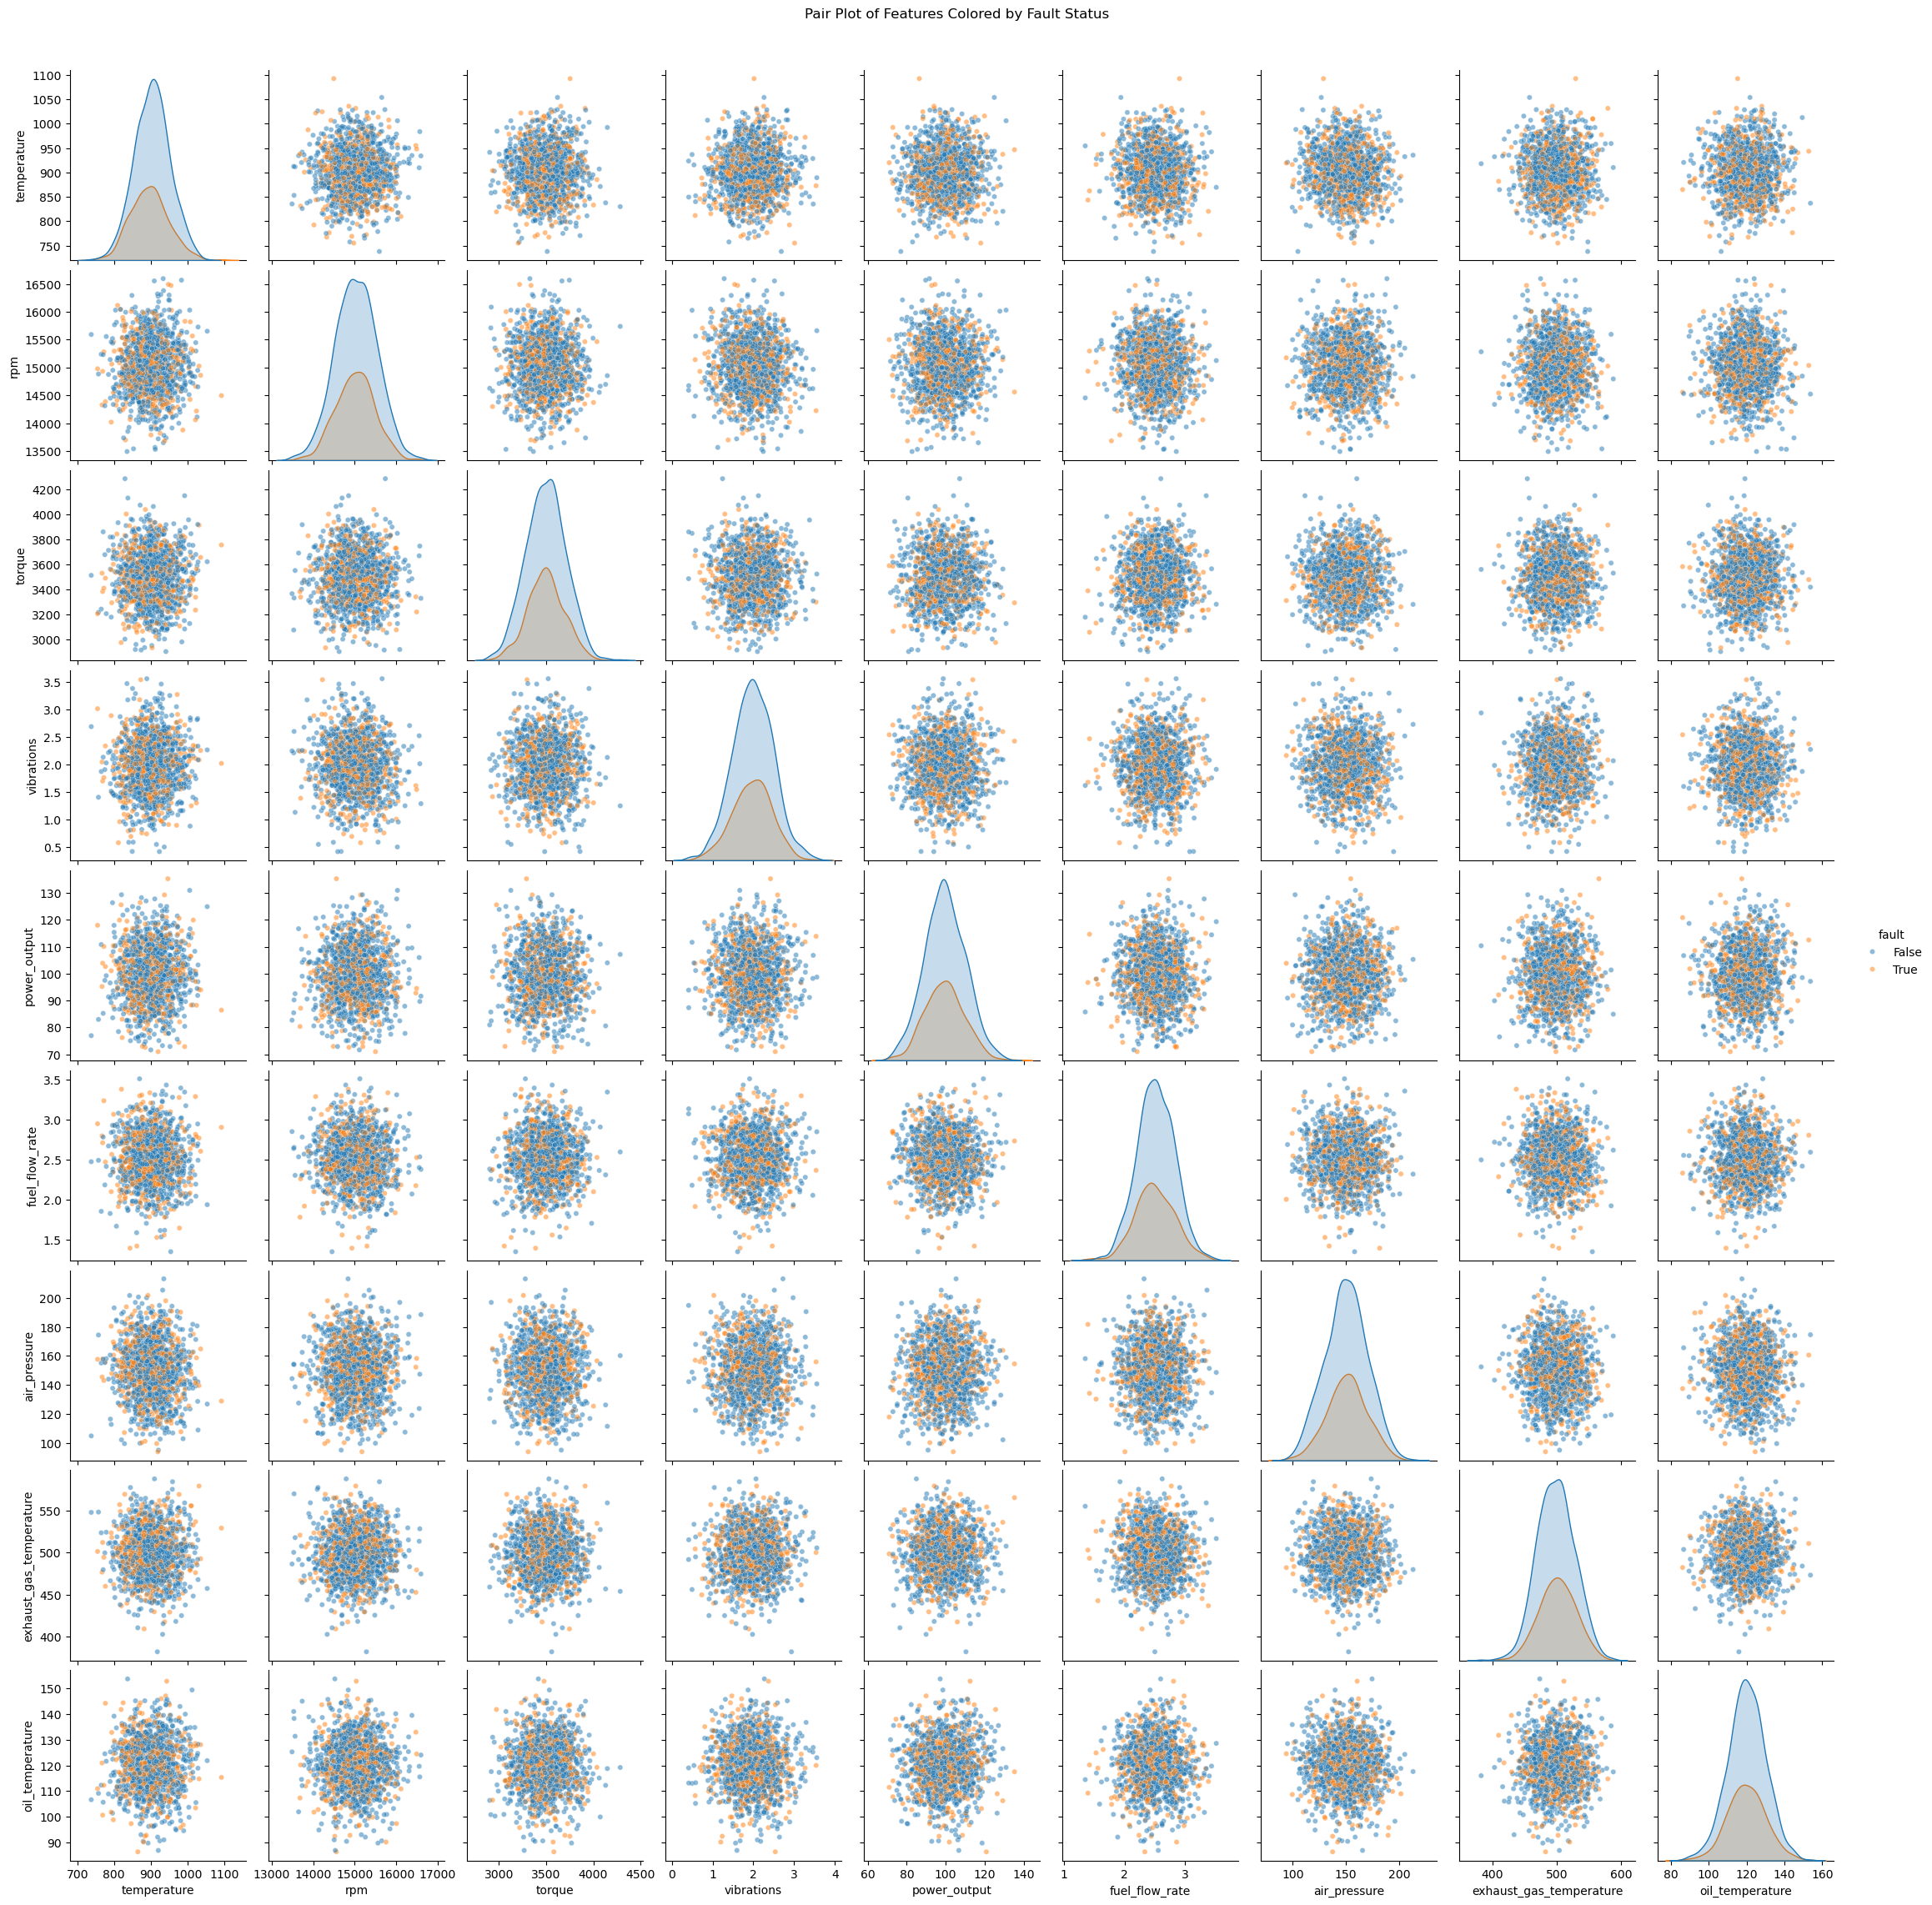

In [ ]:
# Create pair plots to visualize relationships between features colored by fault status
sns.pairplot(df, hue='fault', diag_kind='kde', plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle('Pair Plot of Features Colored by Fault Status', y=1.02)
plt.show()

The pair plot above visualizes the pairwise relationships between all numeric features in the dataset, with points colored by fault status (False = no fault, True = fault). Each diagonal plot shows the distribution of a single feature, while the off-diagonal plots display scatter plots for each feature pair. The distributions and scatter plots indicate that there is significant overlap between the fault and non-fault classes for all feature combinations, with no clear separation or clustering based on fault status. This suggests that distinguishing faults may require more complex, multivariate modeling rather than relying on simple thresholds or individual feature relationships.

## Outlier Detection

In [ ]:
# Lets perform outlier detection
# Import Isolation Forest for outlier detection
from sklearn.ensemble import IsolationForest
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
# Fit the model to the data
features = [col for col in df.columns if col not in ['fault']]
outliers = iso_forest.fit_predict(df[features])
# Convert the outliers to a boolean mask
outliers_mask = outliers == -1
# Add the outliers to the DataFrame
df['outlier'] = outliers_mask

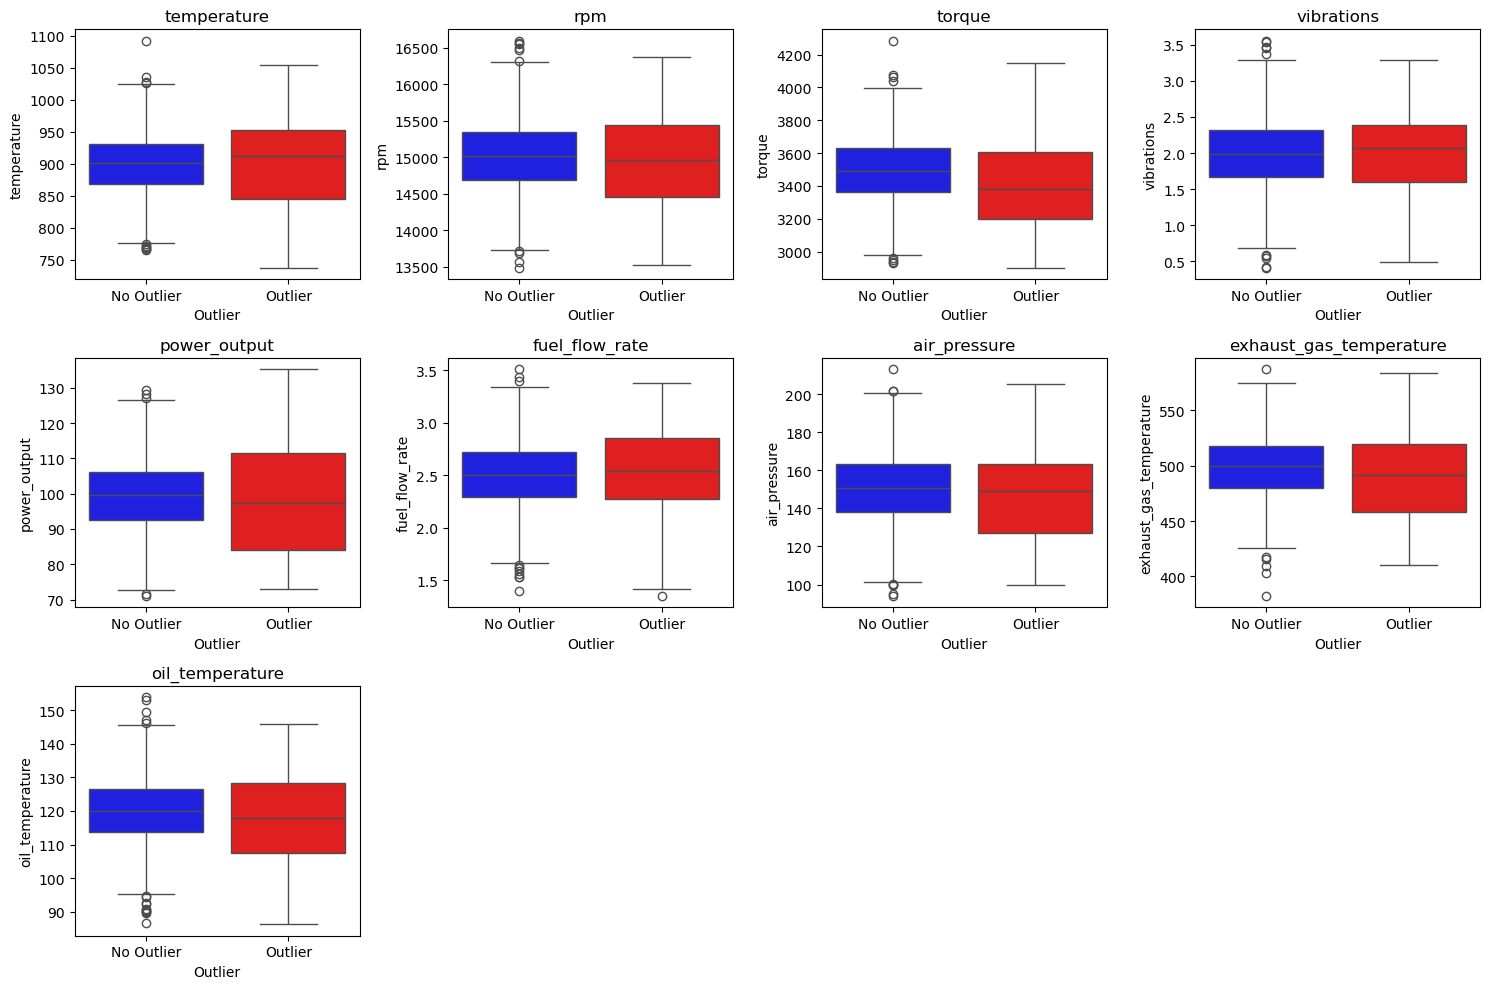

In [ ]:
# Example: Visualize all outliers   
plt.figure(figsize=(15, 10))

for i, column in enumerate(df[numeric_cols]):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='outlier', y=column, data=df, palette={'True': 'red', 'False': 'blue'})
    plt.title(column)
    plt.xlabel('Outlier')
    plt.xticks([0, 1], ['No Outlier', 'Outlier'])
plt.tight_layout()
# Show the plot
plt.show()

The boxplots for various features in the dataset, grouped by the outlier status detected by the Isolation Forest. Each boxplot compares the distribution of a feature for data points classified as "No Outlier" (blue) and "Outlier" (red). The following observations can be made:

1. **Temperature, RPM, Torque, and Vibrations:**
Outliers (red) generally have a wider range and higher median values compared to non-outliers (blue).

2. **Power Output, Fuel Flow Rate, Air Pressure, and Exhaust Gas Temperature:**
Outliers exhibit slightly higher medians and interquartile ranges, with some extreme values outside the whiskers.

3. **Oil Temperature:**
Outliers show a broader spread and higher median compared to non-outliers.

In [ ]:
# Show distribution of the new feature
# plt.figure(figsize=(8, 6))
# sns.histplot(df['power_torque_ratio'], kde=True)
# plt.title('Distribution of Power to Torque Ratio')
# plt.xlabel('Power to Torque Ratio')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# Visulize the relationship between the new feature and the target variable
# plt.figure(figsize=(8, 6))
# sns.boxplot(x='fault', y='power_torque_ratio', data=df)
# plt.title('Power to Torque Ratio by Fault Status')
# plt.xlabel('Fault')
# plt.ylabel('Power to Torque Ratio')
# plt.show()

The boxplot above compares the distribution of the Power to Torque Ratio between normal (Fault = False) and fault (Fault = True) conditions. Both groups have similar median values and interquartile ranges, indicating that the Power to Torque Ratio does not differ significantly between fault and non-fault cases. There are some outliers in both groups, but overall, this feature alone does not provide strong separation between the two classes. This suggests that additional features or combinations of features may be needed to effectively distinguish between fault and normal states.